# 1. Getting Started with PRS-CSx

## Setting Up PRS-CSx

- **0. Create a folder to be your working directory. Let's name it `user_test` for the purpose of subsequent explanations.**
    <br>

- **1. Clone the PRS-CSx repository using the following git command**:
    ```bash
    git clone https://github.com/getian107/PRScsx.git
    ```

    Alternatively, download the source files from the [GitHub website](https://github.com/getian107/PRScsx) to `user_test`.
    <br>

- **2. In `user_test`, create a sub-folder named `ref`. Download the LD reference panels to `ref` and extract files**:
    LD reference panels constructed using the 1000 Genomes Project phase 3 samples:

    - EAS reference (~4.33G): 
        ```bash
        wget https://www.dropbox.com/s/7ek4lwwf2b7f749/ldblk_1kg_eas.tar.gz?dl=0
        tar -zxvf ldblk_1kg_eas.tar.gz
        ```

    - EUR reference (~4.56G): 
        ```bash
        wget https://www.dropbox.com/s/mt6var0z96vb6fv/ldblk_1kg_eur.tar.gz?e=1&dl=0
        tar -zxvf ldblk_1kg_eur.tar.gz
        ```

    Note that these files are identical to the reference panels used in PRS-CS. Therefore, there is no need to download again if you are already using PRS-CS.

    For regions that don't have access to Dropbox, reference panels can be downloaded from the alternative download site.
    <br>

- **3. Download the SNP information file and put it in the same folder containing the reference panels**:
    - 1000 Genomes reference: SNP info (~106M): 
        ```bash
        wget https://www.dropbox.com/s/rhi806sstvppzzz/snpinfo_mult_1kg_hm3?dl=0
        ```
    <br>

- **4. PRScsx requires Python packages `scipy` and `h5py` installed**:
    - [scipy](https://www.scipy.org/)
    - [h5py](https://www.h5py.org/)
    <br>

- **5. Once Python and its dependencies have been installed, running the following will print a list of command-line options.**:
    ```bash
    ./PRScsx.py --help 
    # or 
    ./PRScsx.py -h
    ```

## Using PRS-CSx with Test Data
The test data contains EUR and EAS GWAS summary statistics and a bim file for 1,000 SNPs on chromosome 22. An example to use the test data:
```bash
python PRScsx.py --ref_dir=path_to_ref --bim_prefix=path_to_bim/test --sst_file=path_to_sumstats/EUR_sumstats.txt,path_to_sumstats/EAS_sumstats.txt --n_gwas=200000,100000 --pop=EUR,EAS --chrom=22 --phi=1e-2 --out_dir=path_to_output --out_name=test
```
The test data analysis would be finished in approximately 1 min when using 8Gb of RAM.

Example use given that the reference panels are downloaded in a folder named `ref` and that the current working directory is where PRScsx.py is located:
1. Create a directory to store output:
    ```bash
    mkdir -p ../output
    ```
    
2. Run PRS-CSx: <br>
    ```bash
    python PRScsx.py --ref_dir=../ref --bim_prefix=./test_data/test --sst_file=./test_data/EUR_sumstats.txt,./test_data/EAS_sumstats.txt --n_gwas=200000,100000 --pop=EUR,EAS --chrom=22 --phi=1e-2 --out_dir=../output --out_name=test
    ```

# 2. Preparing for Phenotype Simulation

### Import python packages:

In [18]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

### Set the current working directory:

In [12]:
# Set current working directory to the user_test folder
# os.chdir("path_to_user_test/user_test")
os.chdir("/Users/aliceyan/Desktop/huang_lab_yanruoz/wcpg2023/user_test") 

# Check current working directory
cwd = os.getcwd()
print(f"Current working directory: {cwd}")

Current working directory: /Users/aliceyan/Desktop/huang_lab_yanruoz/wcpg2023/user_test


### Cut the PRS-CSx output files to keep only the rsid and the effect size:

In [19]:
# Define directories for input files
prs_output_EAS = cwd + '/output/test_EAS_pst_eff_a1_b0.5_phi1e-02_chr22.txt'  
prs_output_EUR = cwd + '/output/test_EUR_pst_eff_a1_b0.5_phi1e-02_chr22.txt'  

# Define directories for output files
cut_prs_output_EAS = cwd + '/output/EAS_var_w.txt'  
cut_prs_output_EUR = cwd + '/output/EUR_var_w.txt' 

# Open the input files, cut the 2nd and 6th column, and output them to the output files
with open(prs_output_EAS, 'r') as infile, open(prs_output_EUR, 'w') as outfile:
    for line in infile:
        columns = line.split()
        if len(columns) >= 6:
            second_column = columns[1]
            sixth_column = columns[5]
            outfile.write(f"{second_column}\t{sixth_column}\n")
            
with open(prs_output_EAS, 'r') as infile, open(cut_prs_output_EAS, 'w') as outfile:
    for line in infile:
        columns = line.split()
        if len(columns) >= 6:
            second_column = columns[1]
            sixth_column = columns[5]
            outfile.write(f"{second_column}\t{sixth_column}\n")

Alternatively, one can do the last step in Linux:

```bash
awk '{print $2 "\t" $6}' test_EAS_pst_eff_a1_b0.5_phi1e-02_chr22.txt > EAS_var_w.txt
awk '{print $2 "\t" $6}' test_EUR_pst_eff_a1_b0.5_phi1e-02_chr22.txt > EUR_var_w.txt
```

### Find overlapping variants and store the info of these variants from both populations:

In [20]:
# Read in the cut files and put them in dictionaries
EAS = pd.read_csv(cut_prs_output_EAS, sep = '\t', header = None)
EUR = pd.read_csv(cut_prs_output_EUR, sep = '\t', header = None)
EAS_dic = dict(zip(EAS[0], EAS[1]))
EUR_dic = dict(zip(EAS[0], EAS[1]))

# Find overlapping rsid variants and create a new dictionary with these variants and a tuple of values from both dictionaries
overlap_var = set(EAS_dic.keys()).intersection(set(EUR_dic.keys()))
overlap_var_list = list(overlap_var)
combined_dict = {key: (EAS_dic[key], EUR_dic[key]) for key in overlap_var}

# Write the common variants to a txt file
with open(cwd + '/output/overlap_risk_variants.txt', 'w') as f:
    for key in overlap_var:
        f.write(f"{key}\n")

### Extract Genotype Information for EAS Population on chr22

- **Download the 1kg genotype data to `user_test` folder**:
    ```bash
    wget https://github.com/yanruoz/prs-csx-workshop-tutorial/blob/main/integrated_call_samples_v3.20130502.ALL.panel
    ```

- **Download `chr22_phase3_b_no_dup` bfiles to `user_test` folder and unzip**:
    ```bash
    wget https://github.com/yanruoz/prs-csx-workshop-tutorial/blob/main/chr22_phase3_b_no_dup.zip
    unzip chr22_phase3_b_no_dup.zip
    ```

- **Ensure `plink2` and `plink` are downloaded**:
    - [plink2](https://www.cog-genomics.org/plink/2.0/)
    - [plink](https://www.cog-genomics.org/plink/)

- **Make sure to either work under the `user_test` folder directory or use the absolute path for each file**.

- **Extract sample ID for EAS population using Linux**:
    ```bash
    awk '$3 == "EAS" {print $1}' integrated_call_samples_v3.20130502.ALL.panel > EAS_samples.txt
    ```

- **Keep only EAS samples using `plink2`**:
    ```bash
    plink2 --bfile ./chr22_phase3_b_no_dup/chr22_phase3_b_no_dup --keep EAS_samples.txt --make-bed --out chr22_phase3_b_no_dup_eas
    ```

- **Using `plink`, extract overlapping variants and recode to a format where rows = individuals, columns = ID, other info, and all variants' rsid, entries = allele count**:
    ```bash
    plink --bfile ./chr22_phase3_b_no_dup/chr22_phase3_b_no_dup --extract ./output/overlap_risk_variants.txt --recode A --out ./output/extracted_genotypes_overlap_eas
    ```

- **Remove the first 6 columns to start from variant using Linux**:
    ```bash
    cut -d$'\t' -f7- ./output/extracted_genotypes_overlap_eas.raw > ./output/extracted_genotypes_overlap_var_only_eas.raw
    ```

### Prepare the weight matrices W_eas & W_eur

In [5]:
# W_eas
pd.set_option('display.float_format', lambda x: '%.10f' % x)
EAS_var_w = pd.read_csv(cwd + '/output/EAS_var_w.txt', sep = '\t', header = None, float_precision = 'high')
W_eas = EAS_var_w[EAS_var_w[0].isin(overlap_var_list)][[1]]
W_eas = W_eas.values

# W_eur
EUR_var_w = pd.read_csv(cwd + '/output/EUR_var_w.txt', sep = '\t', header = None, float_precision = 'high')
W_eur = EUR_var_w[EUR_var_w[0].isin(overlap_var_list)][[1]]
W_eur = W_eur.values

# 3. Conduct Simulation of Phenotype Y_height_eas

In [6]:
# read in X
X = pd.read_csv(cwd + "/output/extracted_genotypes_overlap_var_only_eas.raw", sep = '\t')

In [7]:
# sanity check if the column in X matches variants in the weight documents
# obtain rsid list for X
X_rsid = X.columns.tolist()
X_rsid = [i[:-2] for i in X_rsid]

# obtain rsid lists for corresponding weights in the 2 pops
W_eas_rsid = EAS_var_w[EAS_var_w[0].isin(overlap_var_list)][[0]]
W_eas_rsid = W_eas_rsid[0].tolist()
W_eur_rsid = EUR_var_w[EUR_var_w[0].isin(overlap_var_list)][[0]]
W_eur_rsid = W_eur_rsid[0].tolist()

# check if the rsid are the same in the same order
print(W_eas_rsid == X_rsid and W_eur_rsid == X_rsid)

True


In [8]:
# set parameters
a = 0.9
b = 0.1

# initial matrix
Y_prime_eas = a * X.dot(W_eas) + b * X.dot(W_eur)

### Conduct no-standardization simulation

In [9]:
# no standardization simulation
mean_Y_prime_eas = Y_prime_eas.mean()
std_Y_prime_eas = Y_prime_eas.std()
std_envi = std_Y_prime_eas
np.random.seed(134)
epsilon_nonstd = np.random.normal(loc = 0, scale = std_envi, size = Y_prime_eas.shape)
Y_doubleprime_eas_nonstd = Y_prime_eas + epsilon_nonstd
print(Y_doubleprime_eas_nonstd)
np.savetxt('phen_simu_nonstd.txt', Y_doubleprime_eas_nonstd, fmt='%.10f', delimiter='\t')

               0
0   0.0424964469
1   0.0808072236
2   0.0603830807
3   0.0781457613
4   0.0902433265
..           ...
499 0.0550284115
500 0.0469193046
501 0.0339300851
502 0.0468979374
503 0.0319578588

[504 rows x 1 columns]


### Plot no-standardization simulation

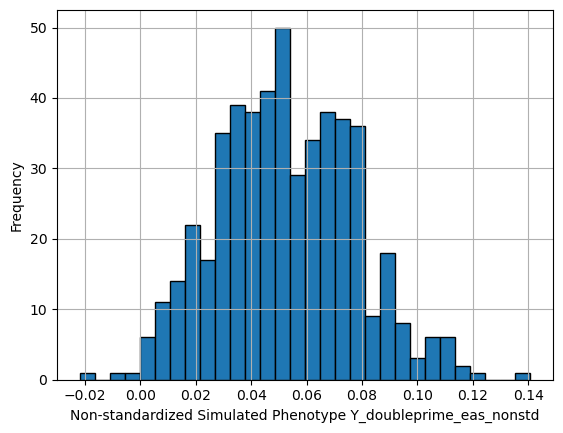

/Users/aliceyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/aliceyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/aliceyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/aliceyan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

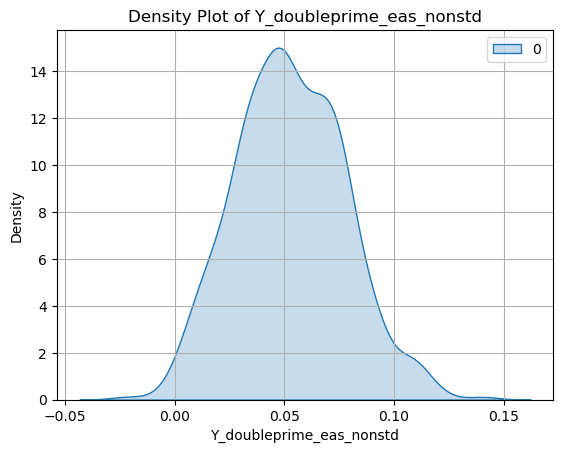

In [10]:
plt.figure()
plt.hist(Y_doubleprime_eas_nonstd, bins = 30, edgecolor = 'k')
plt.xlabel('Non-standardized Simulated Phenotype Y_doubleprime_eas_nonstd')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.figure()
sns.kdeplot(Y_doubleprime_eas_nonstd, fill=True)
plt.title('Density Plot of Y_doubleprime_eas_nonstd')
plt.xlabel('Y_doubleprime_eas_nonstd')
plt.grid(True)
plt.show()

### Append the simulated phenotype to each individual

In [19]:
X['phen'] = Y_doubleprime_eas_nonstd
print(X)
np.savetxt('genotype_phenotype_1kgEAS.txt', X, fmt='%.10f', delimiter='\t')

     rs9605903_T  rs5746647_G  rs5747999_C  rs2845380_A  rs2247281_G  \
0              2            0            0            0            2   
1              2            0            1            0            1   
2              1            0            2            0            1   
3              2            0            0            0            1   
4              2            0            1            0            0   
..           ...          ...          ...          ...          ...   
499            2            0            1            0            0   
500            0            0            2            0            1   
501            0            0            1            1            2   
502            1            0            2            1            1   
503            1            0            2            0            2   

     rs2845346_C  rs2845347_C  rs1807512_T  rs5748593_T  rs9606468_T  ...  \
0              0            0            2            0   

### Split validationa and test dataset

In [12]:
# Split into validation and test dataset -- Genotype Matrix X
X_vali = X.sample(n = 202, random_state = 154)
X_test = X.drop(X_vali.index)
X_vali = X_vali.values
X_test = X_test.values

X_vali_var = X_vali[:, :-1]
X_test_var = X_test[:, :-1]
phen_vali = X_vali[:, -1]
phen_test = X_test[:, -1]

### Regression Analysis on Validation Dataset

In [13]:
# Prepare the model input
X_XWeas_vali = X_vali_var.dot(W_eas).flatten()
X_XWeur_vali = X_vali_var.dot(W_eur).flatten()
X_mix = np.column_stack((X_XWeas_vali, X_XWeur_vali))
y = phen_vali

In [14]:
# Fit the model/Run linear regression
model = LinearRegression()
model.fit(X_mix, y)

LinearRegression()

In [15]:
# Obtain the regression parameters
a_hat = model.coef_[0]
b_hat = model.coef_[1]
intercept = model.intercept_
print(f"{a_hat =}")
print(f"{b_hat =}")
print(f"{intercept =}")

a_hat =0.8391913635028387
b_hat =0.1481060908791269
intercept =-0.0014605554366284301


### Predicting Heights for Test Dataset

In [16]:
X_XWeas_test = X_test_var.dot(W_eas).flatten()
X_XWeur_test = X_test_var.dot(W_eur).flatten()
y_hat = a_hat * X_XWeas_test + b_hat * X_XWeur_test + intercept

### Evaluation based on the pearson correlation coefficient on the testing cohort

In [17]:
r_value, p_value = pearsonr(y_hat, phen_test)
print(f"{r_value =}")
print(f"{p_value =}")

r_value =0.7207798445123292
p_value =1.1342430695948736e-49


In [18]:
r2 = r2_score(phen_test, y_hat)
print(f"{r2 = }")

r2 = 0.51359371619536
